# Hands on introduction to ancient microbiome analysis
Author: Maxime Borry  
Date: August 2024

In this tutorial, we're going to go through the steps necessary to:
- generate a taxonomic profile table with [metaphlan v3.0](https://github.com/biobakery/MetaPhlAn)
- have a look at metaphlan results with [Pavian](https://github.com/fbreitwieser/pavian) and generate a [Krona plot](https://github.com/marbl/Krona/wiki)
- Compare the diversity of our samples vs the diversity of modern human gut samples
- Compare the composition of our samples vs modern gut samples, and see where they fit in a lower dimensional space

Throughout the tutorial, you will have to answer questions highlighted in a green box like below

<div class="alert alert-block alert-success">
This is a question box
</div>

Whenever you encounter a question, you should answer it on particify, using the following link: [partici.fi/94073316](https://partici.fi/94073316)

## 0. Quick intro to Jupyter Notebooks

This a markdown cell

In [1]:
print("This is a python cell")

This is a python cell


In [2]:
! echo "This is how to run a single line bash command"

This is how to run a single line bash command


In [3]:
%%bash
echo "This how to run a multi"
echo "lines bash command"

This how to run a multi
lines bash command


## 1. Data pre-processing

Before starting to analyze our data, we will need to pre-process them to remove reads mapping to the host genome, here, *Homo sapiens*

To do so, I've used [nf-core/eager](https://github.com/nf-core/eager)

I've already pre-processed the data, and the resulting cleaned files are available in the [data/eager_cleaned](data/eager_cleaned), but the basic eager command to do so is:

` nextflow run nf-core/eager -profile <docker/singularity/podman/conda/institute> --input '*_R{1,2}.fastq.gz' --fasta 'human_genome.fasta' --hostremoval_input_fastq`

## 2. Adapter sequence trimming and low-quality bases trimming

Sequencing adapters are small DNA sequences adding prior to DNA sequencing to allow the DNA fragments to attach to the sequencing flow cells. Because these adapters could interfere with downtstream analyses, we need to remove them before proceeding any further.
Furthermore, because the quality of the sequencing is not always optimal, we need to remove bases of lower sequencing quality to might lead to spurious results in downstream analyses.

To perform both of these tasks, we'll use the program [fastp](https://github.com/OpenGene/fastp).

In [4]:
! fastp -h

option needs value: --html
usage: fastp [options] ... 
options:
  -i, --in1                            read1 input file name (string [=])
  -o, --out1                           read1 output file name (string [=])
  -I, --in2                            read2 input file name (string [=])
  -O, --out2                           read2 output file name (string [=])
      --unpaired1                      for PE input, if read1 passed QC but read2 not, it will be written to unpaired1. Default is to discard it. (string [=])
      --unpaired2                      for PE input, if read2 passed QC but read1 not, it will be written to unpaired2. If --unpaired2 is same as --unpaired1 (default mode), both unpaired reads will be written to this same file. (string [=])
      --overlapped_out                 for each read pair, output the overlapped region if it has no any mismatched base. (string [=])
      --failed_out                     specify the file to store reads that cannot pass the filters. (

In [5]:
%%bash
fastp \
    --in1 ../data/subsampled/ERR5766177_PE.mapped.hostremoved.fwd.fq_subsample_1000000.fastq.gz \
    --in2 ../data/subsampled/ERR5766177_PE.mapped.hostremoved.fwd.fq_subsample_1000000.fastq.gz \
    --merge \
    --merged_out ../results/fastp/ERR5766177.merged.fastq.gz \
    --include_unmerged \
    --dedup \
    --json ../results/fastp/ERR5766177.fastp.json \
    --html ../results/fastp/ERR5766177.fastp.html \

Read1 before filtering:
total reads: 1000000
total bases: 101000000
Q20 bases: 99440729(98.4562%)
Q30 bases: 94683150(93.7457%)

Read2 before filtering:
total reads: 1000000
total bases: 101000000
Q20 bases: 99440729(98.4562%)
Q30 bases: 94683150(93.7457%)

Merged and filtered:
total reads: 1994070
total bases: 201397311
Q20 bases: 198330382(98.4772%)
Q30 bases: 188843149(93.7665%)

Filtering result:
reads passed filter: 1999252
reads failed due to low quality: 728
reads failed due to too many N: 20
reads failed due to too short: 0
reads with adapter trimmed: 282
bases trimmed due to adapters: 18654
reads corrected by overlap analysis: 0
bases corrected by overlap analysis: 0

Duplication rate: 0.2479%

Insert size peak (evaluated by paired-end reads): 31

Read pairs merged: 228
% of original read pairs: 0.0228%
% in reads after filtering: 0.0114339%


JSON report: ../results/fastp/ERR5766177.fastp.json
HTML report: ../results/fastp/ERR5766177.fastp.html

fastp --in1 ../data/subsampled

<div class="alert alert-block alert-success">
    What do you think of the number of read pairs that were merged ?
</div>

## 3. Taxonomic profiling with Metaphlan

In [6]:
! metaphlan  --help

usage: metaphlan --input_type {fastq,fasta,bowtie2out,sam} [--force]
                 [--bowtie2db METAPHLAN_BOWTIE2_DB] [-x INDEX]
                 [--bt2_ps BowTie2 presets] [--bowtie2_exe BOWTIE2_EXE]
                 [--bowtie2_build BOWTIE2_BUILD] [--bowtie2out FILE_NAME]
                 [--min_mapq_val MIN_MAPQ_VAL] [--no_map] [--tmp_dir]
                 [--tax_lev TAXONOMIC_LEVEL] [--min_cu_len]
                 [--min_alignment_len] [--add_viruses] [--ignore_eukaryotes]
                 [--ignore_bacteria] [--ignore_archaea] [--ignore_ksgbs]
                 [--ignore_usgbs] [--stat_q] [--perc_nonzero]
                 [--ignore_markers IGNORE_MARKERS] [--avoid_disqm] [--stat]
                 [-t ANALYSIS TYPE] [--nreads NUMBER_OF_READS]
                 [--pres_th PRESENCE_THRESHOLD] [--clade] [--min_ab]
                 [--profile_vsc] [--vsc_out VSC_OUT]
                 [--vsc_breadth VSC_BREADTH] [-o output file]
                 [--sample_id_key name] [--use_group_repr

```bash
metaphlan ../results/fastp/ERR5766177.merged.fastq.gz  \
    --input_type fastq \
    --bowtie2out ../results/metaphlan/ERR5766177.bt2.out  \
    --nproc 4 \
    > ../results/metaphlan/ERR5766177.metaphlan_profile.txt
```

The main results files that we're interested in is located at [../results/metaphlan/ERR5766177.metaphlan_profile.txt](../results/metaphlan/ERR5766177.metaphlan_profile.txt)

It's a tab separated file, with taxons in rows, with their relative abundance in the sample

In [7]:
! head ../results/metaphlan/ERR5766177.metaphlan_profile.txt

#mpa_v30_CHOCOPhlAn_201901
#/home/maxime_borry/.conda/envs/maxime/envs/summer_school_microbiome/bin/metaphlan ../results/fastp/ERR5766177.merged.fastq.gz --input_type fastq --bowtie2out ../results/metaphlan/ERR5766177.bt2.out --nproc 8
#SampleID	Metaphlan_Analysis
#clade_name	NCBI_tax_id	relative_abundance	additional_species
k__Bacteria	2	82.23198	
k__Archaea	2157	17.76802	
k__Bacteria|p__Firmicutes	2|1239	33.47957	
k__Bacteria|p__Bacteroidetes	2|976	28.4209	
k__Bacteria|p__Actinobacteria	2|201174	20.33151	
k__Archaea|p__Euryarchaeota	2157|28890	17.76802	


<div class="alert alert-block alert-success">
What is the letter preceding the `__` before every clade name ? Eg. `k__Bacteria`
</div>

## 4. Visualizing the taxonomic profile 
### 4.1 Visualizing metaphlan taxonomic profile with Pavian

[Pavian](https://github.com/fbreitwieser/pavian) is an interactive app to explore results of different taxonomic classifiers

There are different ways to run it:
- If you have [docker](https://www.docker.com/) installed (and are somehow familiar with it)

```bash
docker pull 'florianbw/pavian'
docker run --rm -p 5000:80 florianbw/pavian
```

Then open your browser and visit [localhost:5000](localhost:5000)

- If you are familiar with [R](https://www.r-project.org/)

```r
if (!require(remotes)) { install.packages("remotes") }
remotes::install_github("fbreitwieser/pavian")

pavian::runApp(port=5000)
```

Then open your browser and visit [localhost:5000](localhost:5000)

- Otherwise, just visit [fbreitwieser.shinyapps.io/pavian](https://fbreitwieser.shinyapps.io/pavian/.).

<div class="alert alert-block alert-success">
What is the relative abundance of the phylum Firmicutes ?
</div>

### 4.2 Visualizing metaphlan taxonomic profile with [Krona](https://github.com/marbl/Krona/wiki)

In [8]:
%%bash
python ../scripts/metaphlan2krona.py -p ../results/metaphlan/ERR5766177.metaphlan_profile.txt -k ../results/krona/ERR5766177_krona.out
ktImportText -o ../results/krona/ERR5766177_krona.html ../results/krona/ERR5766177_krona.out

Writing ../results/krona/ERR5766177_krona.html...


<div class="alert alert-block alert-success">
Which proportion of the Firmicutes is made of Clostridiales ?
</div>

## 5. Getting modern reference data

In order to compare our sample with modern reference samples, I used the curatedMetagenomicsData package, which provides both curated metadata, and pre-computed metaphlan taxonomic profiles for published modern human samples. 
The full R code to get these data is available in [curatedMetagenomics/get_sources.Rmd](./curatedMetagenomics/get_sources.Rmd)

I pre-selected 200 gut microbiome samples from non-westernized (100) and westernized (100) from healthy, non-antibiotic users donors.

```R
library(curatedMetagenomicData)
library(tidyverse)

sampleMetadata %>% 
  filter(body_site=='stool' & antibiotics_current_use  == 'no' & disease == 'healthy') %>% 
  group_by(non_westernized) %>% 
  sample_n(100) %>% 
  ungroup() -> selected_samples

selected_samples %>% 
  returnSamples("relative_abundance", rownames = "NCBI") -> rel_ab

data_ranks = splitByRanks(rel_ab)

for (r in names(data_ranks)){
  print(r)
  assay_rank = as.data.frame(assay(data_ranks[[r]]))
  print(paste0("../../data/curated_metagenomics/modern_sources_",tolower(r),".csv"))
  write.csv(assay_rank, paste0("../../data/curated_metagenomics/modern_sources_",tolower(r),".csv"))


```

- The resulting metaphlan taxonomic profiles (split by taxonomic ranks) are available at [../data/curated_metagenomics](../data/curated_metagenomics)
- The associated metadata is available at [../data/metadata/curated_metagenomics_modern_sources.csv](../data/metadata/curated_metagenomics_modern_sources.csv)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Taxonomic_Rank_Graph.svg/800px-Taxonomic_Rank_Graph.svg.png" alt="Taxonomic ranks" width="400">

## 6. Bringing together ancient and modern data

This is the moment where we will the [Pandas](https://pandas.pydata.org) [Python](https://www.python.org/) library to perform some data manipulation.  
We will also use the [Taxopy](https://github.com/apcamargo/taxopy) library to work to taxonomic informations.


In [10]:
import pandas as pd
import taxopy
import pickle
import gzip

And we then create an instance of the taxopy taxonomy database. This could take a few seconds/minutes, as it needs to download the entire NCBI taxonomy before storing in a local database.

```python
taxo_db = taxopy.TaxDb()
```

To speed up the process, a pre-built taxonomy database is provided just below, that we're going to load with pickle.

In [11]:
with gzip.open("../data/taxopy/taxdb.p.gz", 'rb') as p:
    taxo_db = pickle.load(p)

In [12]:
! head ../results/metaphlan/ERR5766177.metaphlan_profile.txt

#mpa_v30_CHOCOPhlAn_201901
#/home/maxime_borry/.conda/envs/maxime/envs/summer_school_microbiome/bin/metaphlan ../results/fastp/ERR5766177.merged.fastq.gz --input_type fastq --bowtie2out ../results/metaphlan/ERR5766177.bt2.out --nproc 8
#SampleID	Metaphlan_Analysis
#clade_name	NCBI_tax_id	relative_abundance	additional_species
k__Bacteria	2	82.23198	
k__Archaea	2157	17.76802	
k__Bacteria|p__Firmicutes	2|1239	33.47957	
k__Bacteria|p__Bacteroidetes	2|976	28.4209	
k__Bacteria|p__Actinobacteria	2|201174	20.33151	
k__Archaea|p__Euryarchaeota	2157|28890	17.76802	


In [13]:
ancient_data = pd.read_csv("../results/metaphlan/ERR5766177.metaphlan_profile.txt", comment="#", delimiter="\t", names=['clade_name','NCBI_tax_id','relative_abundance','additional_species'])

In [14]:
ancient_data.head()

,clade_name,NCBI_tax_id,relative_abundance,additional_species
0,k__Bacteria,2,82.23198,NaN
1,k__Archaea,2157,17.76802,NaN
2,k__Bacteria|p__Firmicutes,2|1239,33.47957,NaN
3,k__Bacteria|p__Bacteroidetes,2|976,28.42090,NaN
4,k__Bacteria|p__Actinobacteria,2|201174,20.33151,NaN


In [15]:
ancient_data.sample(10)

,clade_name,NCBI_tax_id,relative_abundance,additional_species
8,k__Archaea|p__Euryarchaeota|c__Methanobacteria,2157|28890|183925,17.05626,NaN
33,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,2|1239|186801|186802|541000|1263,14.98257,NaN
10,k__Bacteria|p__Actinobacteria|c__Actinobacteria,2|201174|1760,9.39377,NaN
42,k__Bacteria|p__Firmicutes|c__Firmicutes_unclas...,2|1239||||,0.27353,NaN
2,k__Bacteria|p__Firmicutes,2|1239,33.47957,NaN
34,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,2|1239|186801|186802|186803|841,13.57908,NaN
25,k__Bacteria|p__Actinobacteria|c__Coriobacterii...,2|201174|84998|84999|84107,10.19013,NaN
13,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,2|1239|186801|186802,33.20604,NaN
64,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,2|1239|186801|186802|186803|189330|39486,0.07690,NaN
0,k__Bacteria,2,82.23198,NaN


Because for this analysis, we're only going to look at the relative abundance, we'll only this column, an the [TAXID](https://www.ncbi.nlm.nih.gov/taxonomy) information

In [16]:
ancient_data = (
    ancient_data
    .rename(columns={'NCBI_tax_id': 'TAXID'})
    .drop(['clade_name','additional_species'], axis=1)
)

Always investigate your data at first !

In [17]:
ancient_data.relative_abundance.sum()

np.float64(700.00007)

<div class="alert alert-block alert-success">
What do you think of a 700% relative abundance ?
</div>

Let's proceed further and try to understand what's happening.

To make sense of the TAXID, we will use taxopy to get all the taxonomic related informations such as:
- name of the taxon
- rank of the taxon
- lineage of the taxon

In [18]:
# This function is here to help us get the taxon information
# from the metaphlan taxonomic ID lineage, of the following form
# 2|976|200643|171549|171552|838|165179

def to_taxopy(taxid_entry, taxo_db):
    """Returns a taxopy taxon object
    Args:
        taxid_entry(str): metaphlan TAXID taxonomic lineage
        taxo_db(taxopy database)
    Returns:
        (bool): Returns a taxopy taxon object
    """
    taxid = taxid_entry.split("|")[-1] # get the last element 
    try:
        if len(taxid) > 0:
            return taxopy.Taxon(int(taxid), taxo_db) # if it's not empty, get the taxon corresponding to the taxid
        else:
            return taxopy.Taxon(12908, taxo_db) # otherwise, return the taxon associated with unclassified sequences
    except taxopy.exceptions.TaxidError as e:
        return taxopy.Taxon(12908, taxo_db)

In [19]:
ancient_data['taxopy'] = ancient_data['TAXID'].apply(to_taxopy, taxo_db=taxo_db)

In [20]:
ancient_data.head()

,TAXID,relative_abundance,taxopy
0,2,82.23198,s__Bacteria
1,2157,17.76802,s__Archaea
2,2|1239,33.47957,s__Bacteria;c__Terrabacteria group;p__Firmicutes
3,2|976,28.42090,s__Bacteria;c__FCB group;p__Bacteroidetes
4,2|201174,20.33151,s__Bacteria;c__Terrabacteria group;p__Actinoba...


In [21]:
ancient_data = ancient_data.assign(
    rank = ancient_data.taxopy.apply(lambda x: x.rank),
    name = ancient_data.taxopy.apply(lambda x: x.name),
    taxopy_taxid = ancient_data.taxopy.apply(lambda x: x.taxid),
    lineage = ancient_data.taxopy.apply(lambda x: x.name_lineage),
)

In [22]:
ancient_data

,TAXID,relative_abundance,taxopy,rank,name,taxopy_taxid,lineage
0,2,82.23198,s__Bacteria,superkingdom,Bacteria,2,"[Bacteria, cellular organisms, root]"
1,2157,17.76802,s__Archaea,superkingdom,Archaea,2157,"[Archaea, cellular organisms, root]"
2,2|1239,33.47957,s__Bacteria;c__Terrabacteria group;p__Firmicutes,phylum,Firmicutes,1239,"[Firmicutes, Terrabacteria group, Bacteria, ce..."
3,2|976,28.42090,s__Bacteria;c__FCB group;p__Bacteroidetes,phylum,Bacteroidetes,976,"[Bacteroidetes, Bacteroidetes/Chlorobi group, ..."
4,2|201174,20.33151,s__Bacteria;c__Terrabacteria group;p__Actinoba...,phylum,Actinobacteria,201174,"[Actinobacteria, Terrabacteria group, Bacteria..."
...,...,...,...,...,...,...,...
62,2|1239|186801|186802|186803|572511|33039,0.24910,s__Bacteria;c__Terrabacteria group;p__Firmicut...,species,[Ruminococcus] torques,33039,"[[Ruminococcus] torques, Mediterraneibacter, L..."
63,2|201174|84998|84999|84107|1472762|1232426,0.17084,s__Bacteria;c__Terrabacteria group;p__Actinoba...,species,[Collinsella] massiliensis,1232426,"[[Collinsella] massiliensis, Enorma, Coriobact..."
64,2|1239|186801|186802|186803|189330|39486,0.07690,s__Bacteria;c__Terrabacteria group;p__Firmicut...,species,Dorea formicigenerans,39486,"[Dorea formicigenerans, Dorea, Lachnospiraceae..."
65,2|201174|1760|85004|31953|1678|216816,0.05447,s__Bacteria;c__Terrabacteria group;p__Actinoba...,species,Bifidobacterium longum,216816,"[Bifidobacterium longum, Bifidobacterium, Bifi..."


Because our modern data are split by ranks, we'll first split our ancient sample by rank

Which of the entries are at the `species rank` level ?

In [23]:
ancient_species = ancient_data.query("rank == 'species'")

In [24]:
ancient_species.head()

,TAXID,relative_abundance,taxopy,rank,name,taxopy_taxid,lineage
46,2|976|200643|171549|171552|838|165179,25.75544,s__Bacteria;c__FCB group;p__Bacteroidetes;c__B...,species,Prevotella copri,165179,"[Prevotella copri, Prevotella, Prevotellaceae,..."
47,2157|28890|183925|2158|2159|2172|2173,17.05626,s__Archaea;p__Euryarchaeota;c__Methanomada gro...,species,Methanobrevibacter smithii,2173,"[Methanobrevibacter smithii, Methanobrevibacte..."
48,2|1239|186801|186802|541000|1263|40518,14.96816,s__Bacteria;c__Terrabacteria group;p__Firmicut...,species,Ruminococcus bromii,40518,"[Ruminococcus bromii, Ruminococcus, Ruminococc..."
49,2|1239|186801|186802|186803|841|301302,13.57908,s__Bacteria;c__Terrabacteria group;p__Firmicut...,species,Roseburia faecis,301302,"[Roseburia faecis, Roseburia, Lachnospiraceae,..."
50,2|201174|84998|84999|84107|102106|74426,9.49165,s__Bacteria;c__Terrabacteria group;p__Actinoba...,species,Collinsella aerofaciens,74426,"[Collinsella aerofaciens, Collinsella, Corioba..."


Let's do a bit of renaming to prepare for what's coming next

In [25]:
ancient_species = ancient_species[['relative_abundance', 'name']].set_index('name').rename(columns={'relative_abundance':'ERR5766177'})

In [26]:
ancient_species.head()

,ERR5766177
name,
Prevotella copri,25.75544
Methanobrevibacter smithii,17.05626
Ruminococcus bromii,14.96816
Roseburia faecis,13.57908
Collinsella aerofaciens,9.49165


In [27]:
ancient_phylums = ancient_data.query("rank == 'phylum'")

In [28]:
ancient_phylums = ancient_phylums[['relative_abundance', 'name']].set_index('name').rename(columns={'relative_abundance':'ERR5766177'})

Now, let's go back to the 700% relative abundance issue...

In [29]:
ancient_data.groupby('rank')['relative_abundance'].sum()

rank
class            99.72648
family           99.72648
genus            97.56524
no rank           3.25537
order            99.72648
phylum          100.00000
species         100.00002
superkingdom    100.00000
Name: relative_abundance, dtype: float64

Now let's load our modern reference samples

In [30]:
modern_phylums = pd.read_csv("../data/curated_metagenomics/modern_sources_phylum.csv", index_col=0)

In [31]:
modern_species = pd.read_csv("../data/curated_metagenomics/modern_sources_species.csv", index_col=0)

<div class="alert alert-block alert-success">
How would we get a random sample of your species table ?
</div>

Now, let's merge our ancient sample with the modern data in one single table

In [32]:
all_species = ancient_species.merge(modern_species, left_index=True, right_index=True, how='outer').fillna(0)
all_phylums = ancient_phylums.merge(modern_phylums, left_index=True, right_index=True, how='outer').fillna(0)

Finally, let's load the metadata

In [33]:
metadata = pd.read_csv("../data/metadata/curated_metagenomics_modern_sources.csv")

In [34]:
metadata.head()

,study_name,sample_id,subject_id,body_site,antibiotics_current_use,study_condition,disease,age,infant_age,age_category,...,hla_drb11,birth_order,age_twins_started_to_live_apart,zigosity,brinkman_index,alcohol_numeric,breastfeeding_duration,formula_first_day,ALT,eGFR
0,ShaoY_2019,de028ad4-7ae6-11e9-a106-68b59976a384,C01528_ba,stool,no,control,healthy,0.0,4.0,newborn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ZeeviD_2015,PNP_Main_283,PNP_Main_283,stool,no,control,healthy,NaN,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZeeviD_2015,PNP_Validation_55,PNP_Validation_55,stool,no,control,healthy,NaN,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VatanenT_2016,G80275,T014806,stool,no,control,healthy,1.0,NaN,child,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ZeeviD_2015,PNP_Main_363,PNP_Main_363,stool,no,control,healthy,NaN,NaN,adult,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-success">
Why did we use an “outer” join when merging the ancient and modern taxonomic profiles ?
</div>

## 7. Comparing ancient and modern samples

### 7.1 Taxonomic composition

One common plot in microbiome papers in a stacked barplot, often at the phylum or family level.

First, we'll do some renaming, to make the value of the metadata variables a bit easier to understand

In [35]:
group_info = pd.concat(
    [
        (
        metadata['non_westernized']
        .map({'no':'westernized','yes':'non_westernized'}) # for the non_westernized in the modern sample metadata, rename the value levels
        .to_frame(name='group').set_index(metadata['sample_id']) # rename the column to group
        .reset_index()
        ),
        (
        pd.Series({'sample_id':'ERR5766177', 'group':'ancient'}).to_frame().transpose()
        )
    ],
    axis=0, ignore_index=True
)

We need transform our data in [tidy](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) format to plot with [plotnine](https://plotnine.readthedocs.io/en/stable/), a python clone of [ggplot](https://ggplot2.tidyverse.org/index.html).  
We then add the group information (Westernized, non westernized, or ancient sample), and compute the mean abundance for each phylum.

First we transpose the dataframe to have the samples as index, and the phylums as columns

We then add the metadata information

In [36]:
(
    all_phylums
    .transpose()
    .merge(group_info, left_index=True, right_on='sample_id')
)

,Actinobacteria,Apicomplexa,Ascomycota,Bacteroidetes,Basidiomycota,Candidatus Melainabacteria,Chlamydiae,Chloroflexi,Cyanobacteria,Deferribacteres,...,Fusobacteria,Lentisphaerae,Planctomycetes,Proteobacteria,Spirochaetes,Synergistetes,Tenericutes,Verrucomicrobia,sample_id,group
200,20.33151,0.0,0.0,28.42090,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00000,ERR5766177,ancient
0,0.25809,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,4.49959,0.00000,0.0,0.0,0.00000,de028ad4-7ae6-11e9-a106-68b59976a384,westernized
1,10.27631,0.0,0.0,17.44332,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.01486,0.0,0.77098,0.00000,0.0,0.0,0.00784,PNP_Main_283,westernized
2,0.45187,0.0,0.0,82.86400,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.05697,0.00000,0.0,0.0,0.00000,PNP_Validation_55,westernized
3,1.11902,0.0,0.0,69.99087,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,4.07757,0.00000,0.0,0.0,1.99276,G80275,westernized
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,14.26365,0.0,0.0,38.59709,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.19699,0.00000,0.0,0.0,0.00000,KHG_9,non_westernized
196,5.47750,0.0,0.0,14.81828,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,3.64655,0.09964,0.0,0.0,0.00000,A48_01_1FE,non_westernized
197,36.77145,0.0,0.0,10.13908,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,17.64151,0.00000,0.0,0.0,0.00000,KHG_1,non_westernized
198,1.16426,0.0,0.0,57.14031,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.30580,0.70467,0.0,0.0,0.00000,TZ_81781,non_westernized


Now, we need it in the tidy format

In [37]:
tidy_phylums = (
    all_phylums
    .transpose()
    .merge(group_info, left_index=True, right_on='sample_id')
    .melt(id_vars=['sample_id', 'group'], value_name='relative_abundance', var_name='Phylum', ignore_index=True)
)

Finally, we only want to keep the mean relative abundance for each phylum

In [38]:
# tidy_phylums = (
#     tidy_phylums
#     .rename(columns={'Phylum':'phylum_taxid'})
#     .assign(
#         phylum = lambda df: df['phylum_taxid'].apply(lambda x: taxopy.Taxon(x, taxo_db).name)
#     )
# )

In [39]:
tidy_phylums = tidy_phylums.groupby(['group', 'Phylum'])['relative_abundance'].mean().reset_index()

And lastly, we'll keep only the 10 most abundant phylums for our plot

In [40]:
phylum_top_10 = tidy_phylums.groupby(['Phylum'])['relative_abundance'].sum().sort_values(ascending=False).head(10)

In [41]:
import numpy as np

In [42]:
top_tidy_phylumns = (
    tidy_phylums.assign(
        top_phylums = np.where(tidy_phylums.Phylum.isin(phylum_top_10.index), tidy_phylums.Phylum, 'other')
    )
    .groupby(['group', 'top_phylums'])['relative_abundance'].sum().reset_index()
)

In [43]:
from plotnine import *

In [44]:
top_tidy_phylumns

,group,top_phylums,relative_abundance
0,ancient,Actinobacteria,20.331510
1,ancient,Bacteroidetes,28.420900
2,ancient,Candidatus Melainabacteria,0.000000
3,ancient,Euryarchaeota,17.768020
4,ancient,Firmicutes,33.479570
5,ancient,Lentisphaerae,0.000000
6,ancient,Proteobacteria,0.000000
7,ancient,Spirochaetes,0.000000
8,ancient,Synergistetes,0.000000
9,ancient,Verrucomicrobia,0.000000


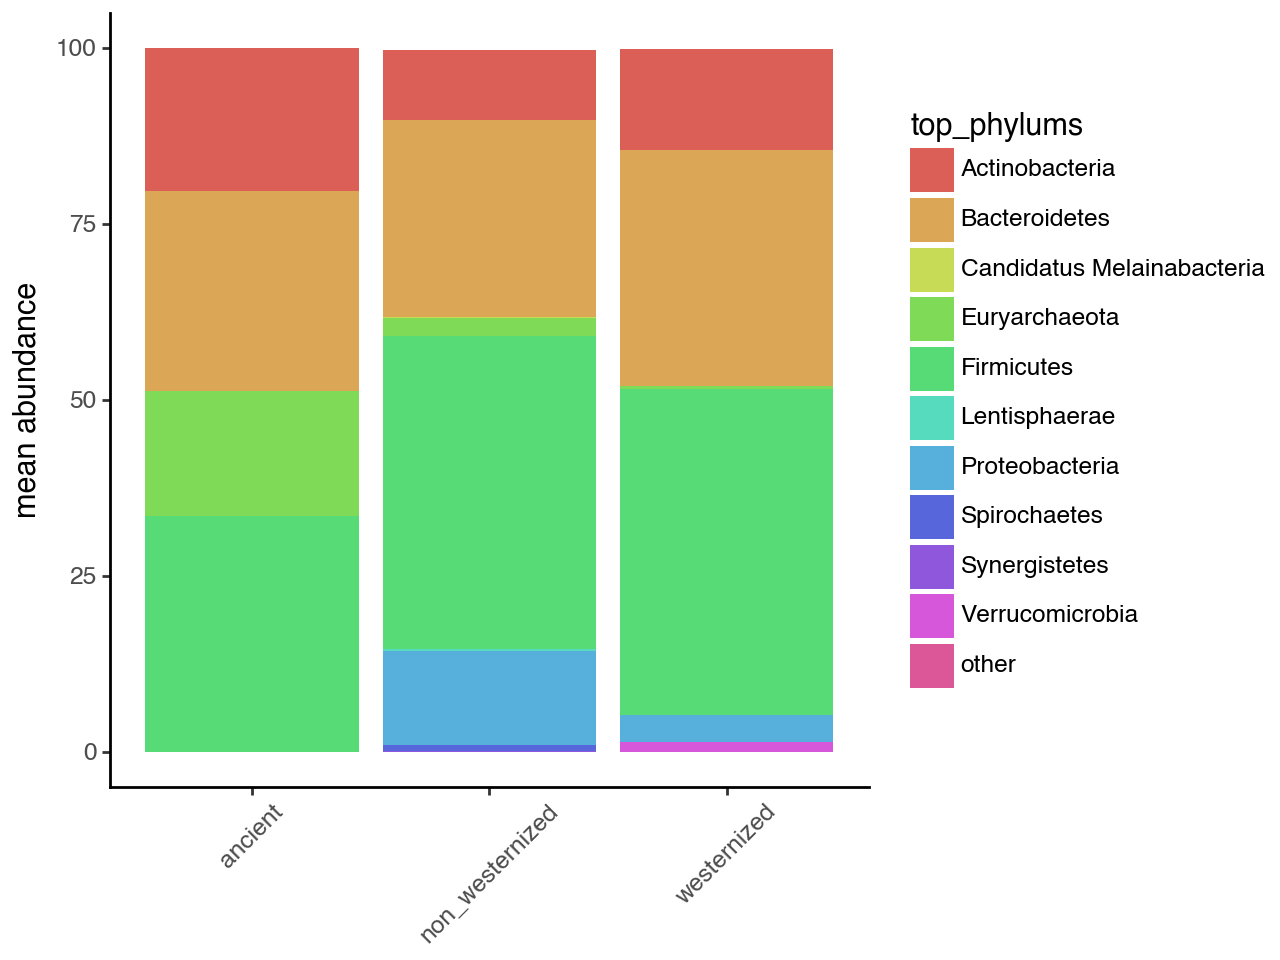

In [45]:
ggplot(
    top_tidy_phylumns, 
    aes(x='group', fill='top_phylums', y='relative_abundance')
    ) \
+ geom_bar(stat='identity') \
+ ylab('mean abundance') \
+ xlab("") \
+ theme_classic() \
+ theme(axis_text_x=element_text(rotation=45))

<div class="alert alert-block alert-success">
What is the most abundant Phylum in all samples ?
</div>

### 7.2 Ecological diversity

#### 7.2.1 Alpha diversity

Alpha diversity is the measure of diversity withing each sample. It is used to estimate how many species are present in a sample, and how diverse they are.  
We'll use the python library [scikit-bio](http://scikit-bio.org/) to compute it, and the [plotnine](https://plotnine.readthedocs.io/) library (a python port of [ggplot2](https://ggplot2.tidyverse.org/reference/ggplot.html) to visualize the results).

In [46]:
import skbio

Let's compute the [species richness](https://en.wikipedia.org/wiki/Species_richness), the [Shannon, and Simpson index of diversity](https://www.biologydiscussion.com/biodiversity/types/2-types-of-diversity-indices-of-biodiversity/8388) index

In [47]:
shannon = skbio.diversity.alpha_diversity(metric='shannon', counts=all_species.transpose(), ids=all_species.columns)
simpson = skbio.diversity.alpha_diversity(metric='simpson', counts=all_species.transpose(), ids=all_species.columns)
richness = (all_species != 0).astype(int).sum(axis=0)
alpha_diversity = (shannon.to_frame(name='shannon')
                   .merge(simpson.to_frame(name='simpson'), left_index=True, right_index=True)
                   .merge(richness.to_frame(name='richness'), left_index=True, right_index=True))
alpha_diversity

,shannon,simpson,richness
ERR5766177,2.102277,0.844769,21
de028ad4-7ae6-11e9-a106-68b59976a384,0.553209,0.251280,11
PNP_Main_283,3.530114,0.954159,118
PNP_Validation_55,2.543962,0.812438,72
G80275,2.655695,0.876712,66
...,...,...,...
KHG_9,2.692381,0.861683,87
A48_01_1FE,3.034429,0.930024,53
KHG_1,2.588096,0.875335,108
TZ_81781,1.997550,0.719491,44


Let's load the group information from the metadata

In [48]:
alpha_diversity = (
    alpha_diversity
    .merge(metadata[['sample_id', 'non_westernized']], left_index=True, right_on='sample_id', how='outer')
    .set_index('sample_id')
    .rename(columns={'non_westernized':'group'})
)
alpha_diversity['group'] = alpha_diversity['group'].replace({'yes':'non_westernized','no':'westernized', pd.NA:'ERR5766177'})

In [49]:
alpha_diversity

,shannon,simpson,richness,group
sample_id,,,,
A01_02_1FE,2.559859,0.887309,78,non_westernized
A03_01_1FE,2.065216,0.732572,32,non_westernized
A04_01_1FE,2.633481,0.838180,110,non_westernized
A04_04_1FE,2.804936,0.895673,105,non_westernized
A06_01_1FE,0.861356,0.383806,9,non_westernized
...,...,...,...,...
ac725ce2-7ae6-11e9-a106-68b59976a384,2.339196,0.817488,38,westernized
cd74a670-7ae6-11e9-a106-68b59976a384,2.319064,0.858835,44,westernized
d7fa5842-7ae6-11e9-a106-68b59976a384,0.755021,0.468075,4,westernized


In [50]:
alpha_diversity = alpha_diversity.melt(id_vars='group', value_name='alpha diversity', var_name='diversity_index', ignore_index=False)

In [51]:
alpha_diversity

,group,diversity_index,alpha diversity
sample_id,,,
A01_02_1FE,non_westernized,shannon,2.559859
A03_01_1FE,non_westernized,shannon,2.065216
A04_01_1FE,non_westernized,shannon,2.633481
A04_04_1FE,non_westernized,shannon,2.804936
A06_01_1FE,non_westernized,shannon,0.861356
...,...,...,...
ac725ce2-7ae6-11e9-a106-68b59976a384,westernized,richness,38.000000
cd74a670-7ae6-11e9-a106-68b59976a384,westernized,richness,44.000000
d7fa5842-7ae6-11e9-a106-68b59976a384,westernized,richness,4.000000


/Users/maxime/miniforge3/envs/summer_school_microbiome/lib/python3.12/site-packages/plotnine/stats/stat_density.py:176: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/Users/maxime/miniforge3/envs/summer_school_microbiome/lib/python3.12/site-packages/plotnine/stats/stat_density.py:181: PlotnineWarning: Groups with fewer than 2 data points have been removed.
/Users/maxime/miniforge3/envs/summer_school_microbiome/lib/python3.12/site-packages/plotnine/stats/stat_density.py:176: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/Users/maxime/miniforge3/envs/summer_school_microbiome/lib/python3.12/site-packages/plotnine/stats/stat_density.py:181: PlotnineWarning: Groups with fewer than 2 data points have been removed.
/Users/maxime/miniforge3/envs/summer_school_microbiome/lib/python3.12/site-packages/plotnine/stats/stat_density.py:176: PlotnineWarning: To compute th

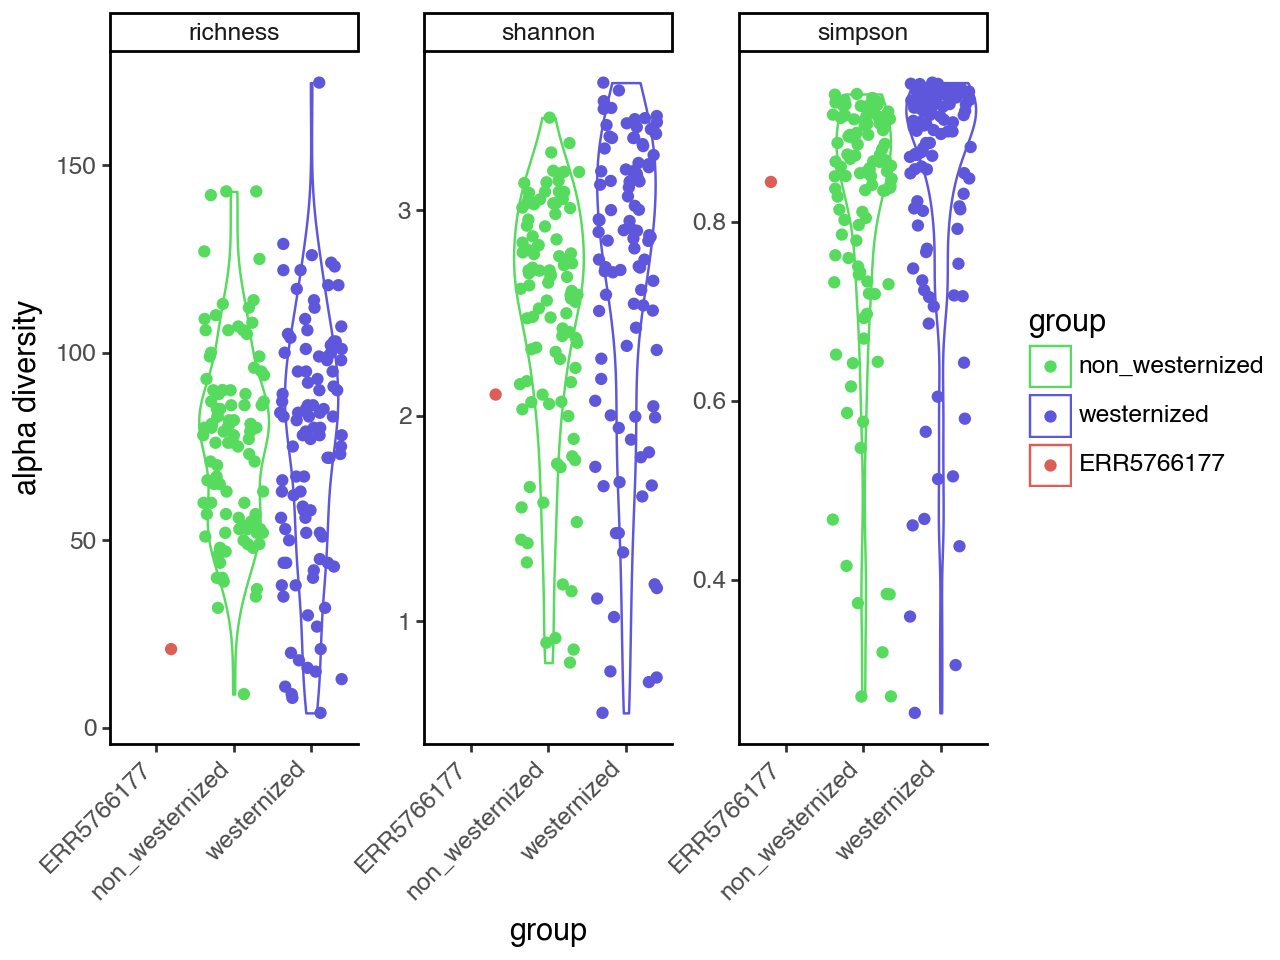

In [52]:
g = ggplot(alpha_diversity, aes(x='group', y='alpha diversity', color='group'))  
g += geom_violin() 
g += geom_jitter() 
g += theme_classic() 
g += facet_wrap('~diversity_index', scales = 'free')
g += theme(axis_text_x=element_text(rotation=45, hjust=1))
g += scale_color_manual({'ERR5766177':'#DB5F57','westernized':'#5F57DB','non_westernized':'#57DB5E'})
g += theme(subplots_adjust={'wspace': 0.15})
g

<div class="alert alert-block alert-success">
Why do we observe a smaller species richness and diversity in our sample ?
</div>

#### 7.2.2 Beta diversity

The Beta diversity is the measure of diversity between a pair of samples. It is used to compare the diversity between samples and see how they relate.

We will compute the beta diversity using the [bray-curtis](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity) dissimilarity

In [53]:
beta_diversity = skbio.diversity.beta_diversity(metric='braycurtis', counts=all_species.transpose(), ids=all_species.columns, validate=True)

We get a distance matrix

In [54]:
print(beta_diversity)

201x201 distance matrix
IDs:
'ERR5766177', 'de028ad4-7ae6-11e9-a106-68b59976a384', 'PNP_Main_283', ...
Data:
[[0.         1.         0.81490039 ... 0.85716612 0.69790092 0.8303726 ]
 [1.         0.         0.99988327 ... 0.99853413 0.994116   0.99877258]
 [0.81490039 0.99988327 0.         ... 0.82311942 0.87202543 0.91363156]
 ...
 [0.85716612 0.99853413 0.82311942 ... 0.         0.84253376 0.76616679]
 [0.69790092 0.994116   0.87202543 ... 0.84253376 0.         0.82409272]
 [0.8303726  0.99877258 0.91363156 ... 0.76616679 0.82409272 0.        ]]


To visualize this distance matrix in a lower dimensional space, we'll use a [PCoA](https://en.wikipedia.org/wiki/Multidimensional_scaling#Types), which is is a method very similar to a PCA, but taking a distance matrix as input.

In [55]:
pcoa = skbio.stats.ordination.pcoa(beta_diversity)

/Users/maxime/miniforge3/envs/summer_school_microbiome/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.25334763387737086 and the largest is 10.20444563033571.


In [56]:
pcoa.samples

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200,PC201
ERR5766177,0.216912,-0.039455,0.107828,0.273309,0.020226,0.115042,-0.256555,-0.150965,0.097321,0.061533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
de028ad4-7ae6-11e9-a106-68b59976a384,-0.099358,0.145226,-0.191675,0.127609,0.119774,-0.132204,-0.097333,0.036819,0.081303,-0.056934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNP_Main_283,-0.214109,-0.147460,0.116034,0.090047,0.076659,0.111522,0.092183,0.026444,-0.006489,-0.019375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PNP_Validation_55,0.244818,-0.174006,-0.311198,-0.012811,0.031754,0.117555,0.148605,-0.135756,0.034729,-0.009244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G80275,-0.261365,-0.077147,-0.254370,-0.065917,0.088517,0.165986,-0.005294,-0.028744,-0.001997,0.015613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KHG_9,0.296057,-0.150306,0.013944,0.032681,-0.147691,0.019666,-0.063185,-0.034436,-0.073480,0.070104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A48_01_1FE,0.110622,0.030964,0.154213,-0.185977,-0.008527,-0.103416,0.028111,-0.044569,0.041919,0.068439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KHG_1,-0.100006,0.167885,0.009913,0.076878,-0.405566,-0.039144,-0.006440,-0.009785,-0.072220,0.149722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TZ_81781,0.405710,-0.139312,-0.075042,-0.079713,-0.053260,-0.119280,0.068282,-0.018843,0.198140,-0.013035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's look at the variance explained by the first axes by using a scree plot

In [57]:
var_explained = pcoa.proportion_explained[:9].to_frame(name='variance explained').reset_index().rename(columns={'index':'PC'})

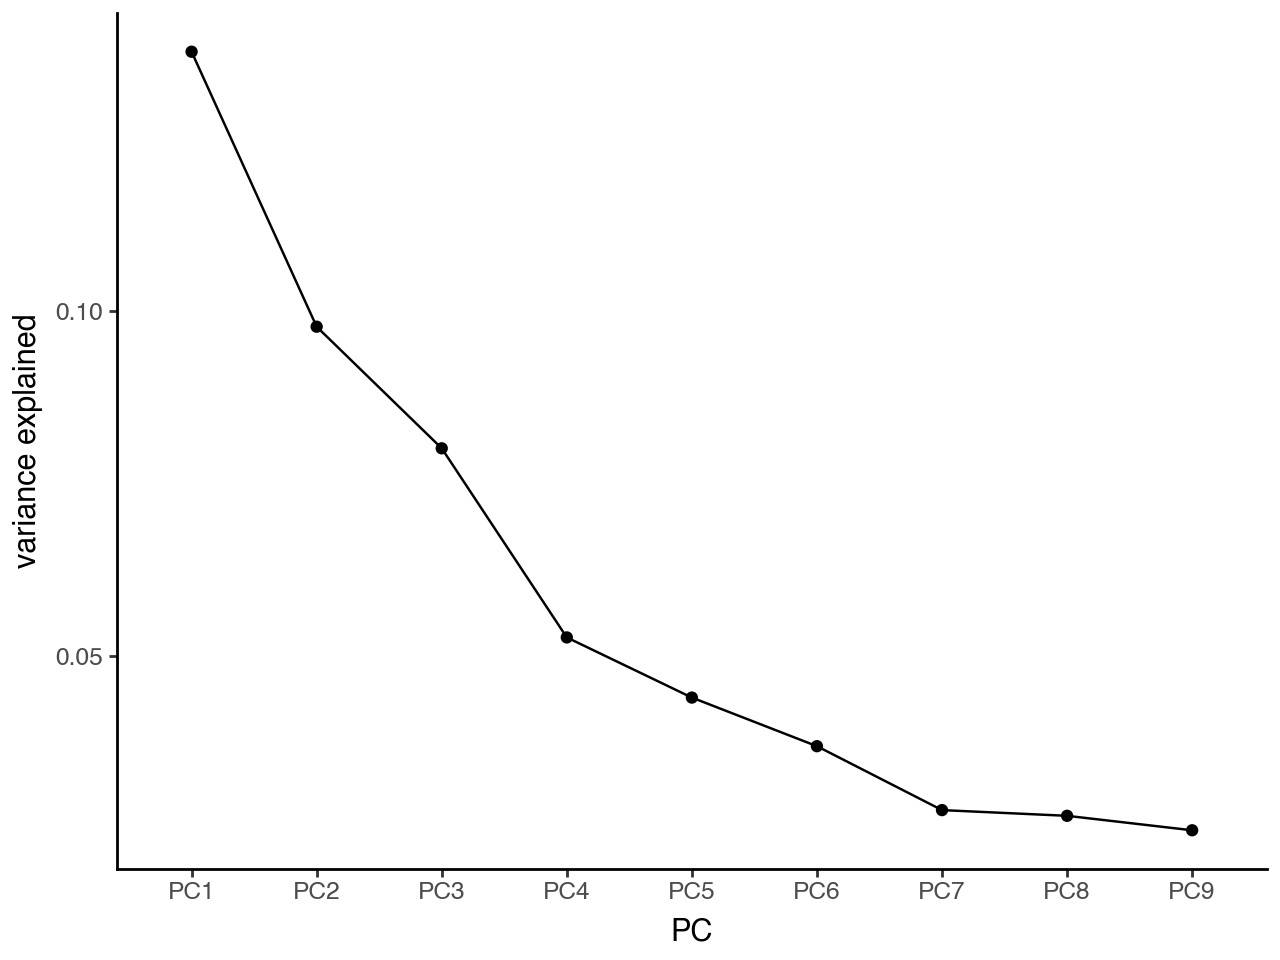

In [58]:
ggplot(var_explained, aes(x='PC', y='variance explained', group=1)) \
+ geom_point() \
+ geom_line() \
+ theme_classic()

In this scree plot, we're looking for the "elbow", where there is a drop in the slope. Here, it seems that most of the variance is captures by the 3 first principal components

In [59]:
pcoa_embed = pcoa.samples[['PC1','PC2','PC3','PC4']].rename_axis('sample').reset_index()

In [60]:
pcoa_embed = (
    pcoa_embed
    .merge(metadata[['sample_id', 'non_westernized']], left_on='sample', right_on='sample_id', how='outer')
    .drop('sample_id', axis=1)
    .rename(columns={'non_westernized':'group'})
)
pcoa_embed['group'] = pcoa_embed['group'].replace({'yes':'non_westernized','no':'westernized', pd.NA:'ERR5766177'})

Let's first look at these components with 2D plots

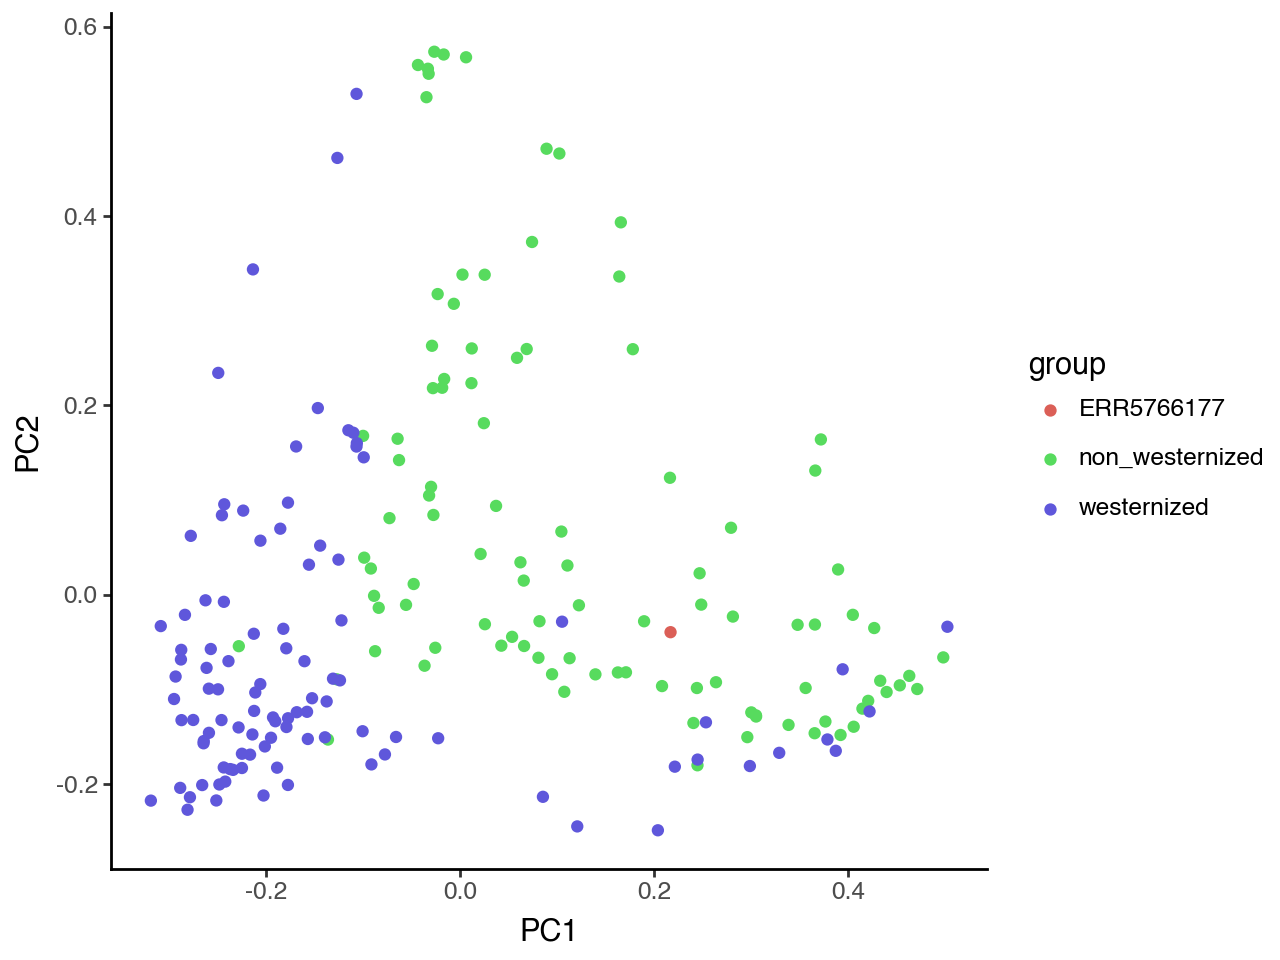

In [61]:
ggplot(pcoa_embed, aes(x='PC1', y='PC2', color='group')) \
+ geom_point() \
+ theme_classic() \
+ scale_color_manual({'ERR5766177':'#DB5F57','westernized':'#5F57DB','non_westernized':'#57DB5E'})

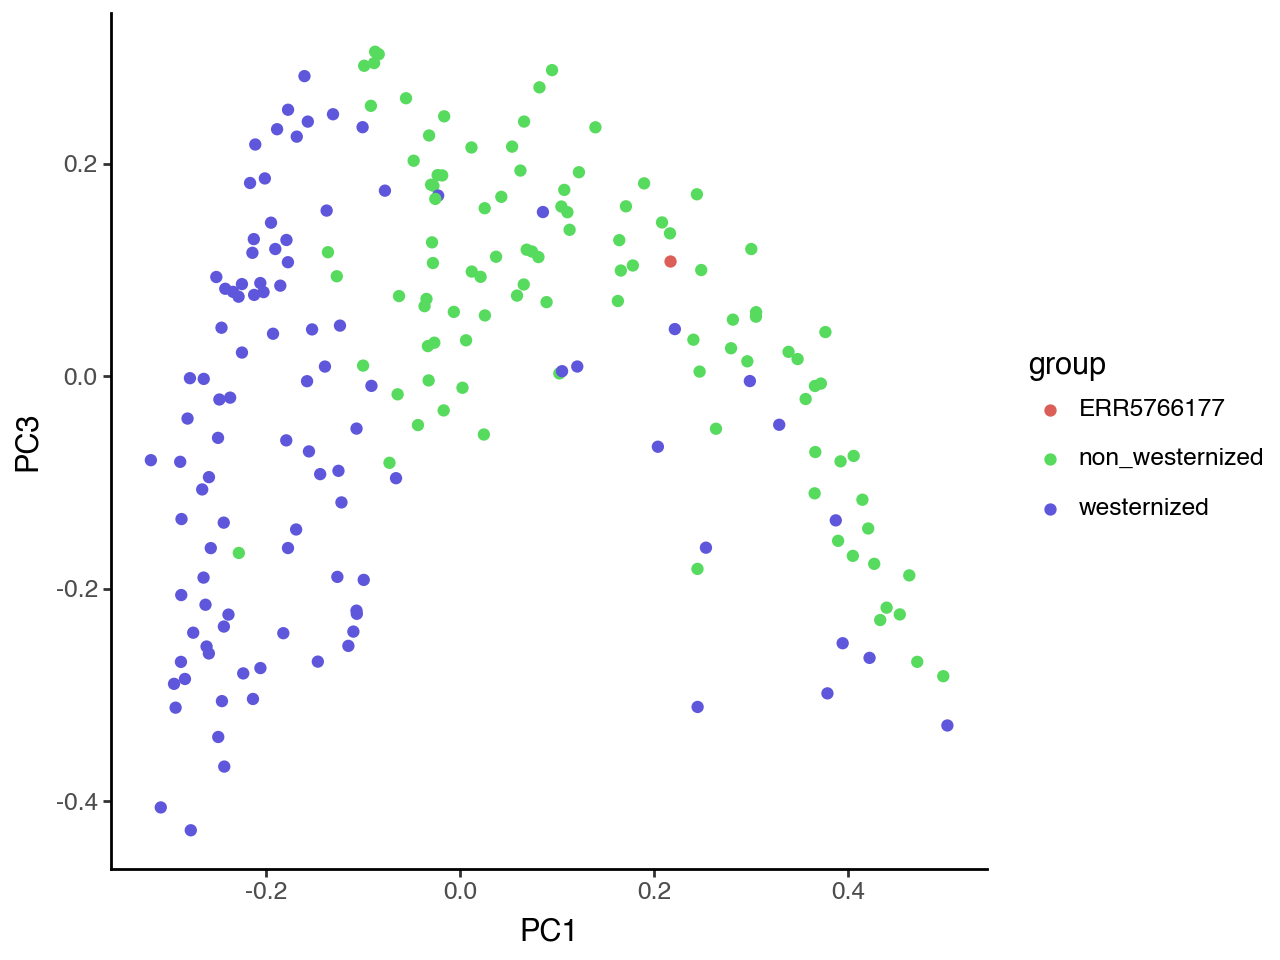

In [62]:
ggplot(pcoa_embed, aes(x='PC1', y='PC3', color='group')) + geom_point() + theme_classic() + scale_color_manual({'ERR5766177':'#DB5F57','westernized':'#5F57DB','non_westernized':'#57DB5E'})

Then with a 3d plot

In [63]:
import plotly.express as px

fig = px.scatter_3d(pcoa_embed, x="PC1", y="PC2", z="PC3", color = "group", color_discrete_map={'ERR5766177':'#DB5F57','westernized':'#5F57DB','non_westernized':'#57DB5E'}, hover_name="sample")
fig.show()

We can also visualize this distance matrix using a clustered heatmap, where pairs of sample with a small beta diversity are clustered together

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [65]:
pcoa_embed['colour'] = pcoa_embed['group'].map({'ERR5766177':'#DB5F57','westernized':'#5F57DB','non_westernized':'#57DB5E'})

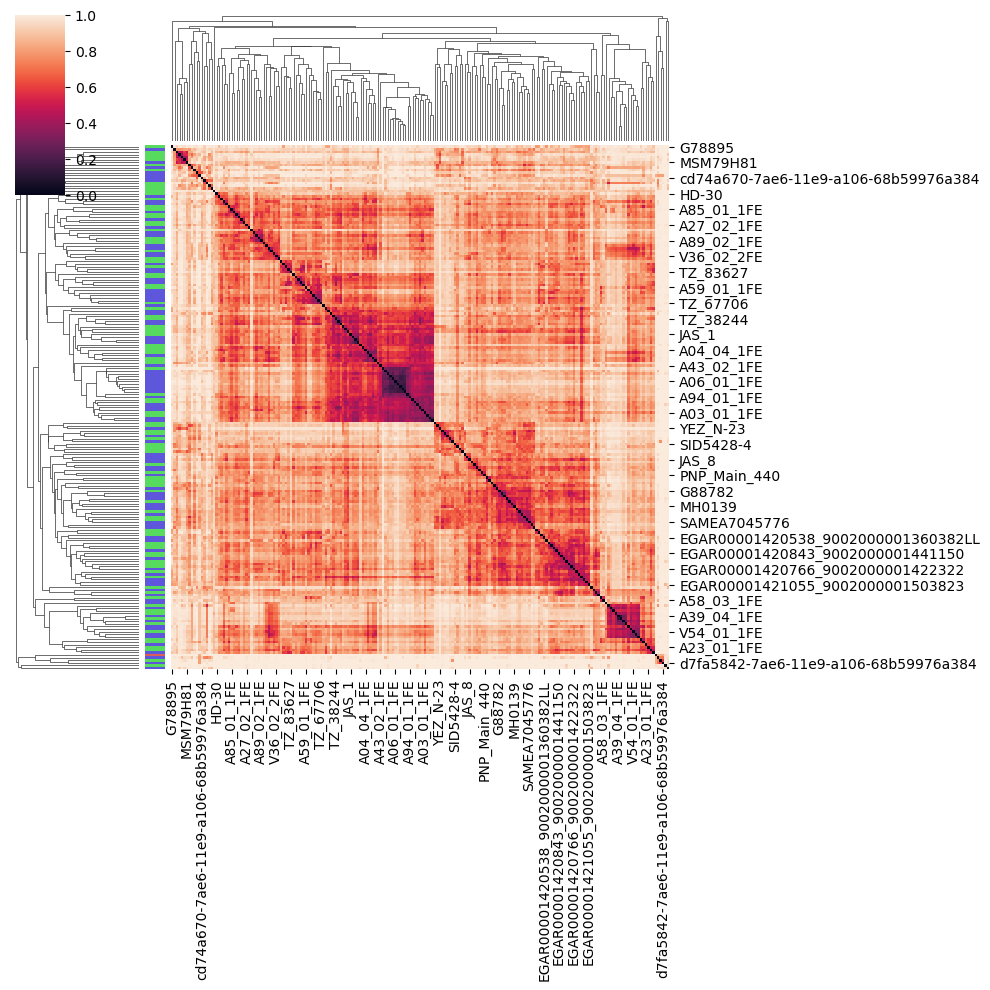

In [66]:
linkage = hc.linkage(sp.distance.squareform(beta_diversity.to_data_frame()), method='average')

sns.clustermap(
    beta_diversity.to_data_frame(),
    row_linkage=linkage, 
    col_linkage=linkage, 
    row_colors = pcoa_embed['colour'].to_list()
)
plt.show()

<div class="alert alert-block alert-success">
Based on the PCoA and heatmap, how you think our ancient sample relates to modern ones ?
</div>